In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import numpy as np
import pandas as pd
import datetime
import os
import csv
import random
import io
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [8, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
num_lags = 3
timesteps = 30
err_range = 0.5

In [13]:
# calculates z-scores for a certain column in a dataframe
def z_score_calc(dataframe,col_name):
    sub = dataframe[col_name]
    mean = sub.mean()
    std = sub.std()
    dataframe['Z Scores'] = (sub - mean) / std
    return dataframe['Z Scores'], mean, std

# generate csv based on number of lags
def make_csv(num_lags,gwl_num,df,col_name,csv_name):
    result = pd.DataFrame()
    pd.DataFrame.reset_index(result, drop=True)
    data = df[col_name]
    pd.DataFrame.reset_index(data, drop=True)
    name = ""
    for i in range(num_lags):
        name = "Max GWL: t-" + str(num_lags-i)
        list_data = data[num_lags+gwl_num-1-i:(len(data)-i)]
        result[name] = np.array(list_data)
    if gwl_num > 1:
        result['Max GWL (predicted,updated): t+' + str(gwl_num-1)] = data[0:len(data)-num_lags-gwl_num+1]
    else:
        result['Max GWL (predicted,updated): t'] = data[0:len(data)-num_lags-gwl_num+1]
    #result = result.sample(frac=1)
    result.to_csv(csv_name)

# j17 data
df_17 = pd.read_csv('../j17_well.csv')
pd.DataFrame.reset_index(df_17, drop=True)
del df_17['Site']
z_scores_17 = pd.DataFrame()
pd.DataFrame.reset_index(z_scores_17, drop=True)
z_scores_17["DailyHighDate"] = df_17['DailyHighDate']
z_scores_17['WaterLevelElevation'] = df_17['WaterLevelElevation']
z_scores_17['Z Scores'], mean_17, std_17 = z_score_calc(df_17,'WaterLevelElevation')
z_scores_17.to_csv("j17_well_z_scores.csv")
make_csv(num_lags,timesteps,z_scores_17,'Z Scores','data_17.csv')
cols_17 = []
for i in range(num_lags):
    cols_17.append(i+1)
ds_x_17 = np.genfromtxt('data_17.csv',delimiter=",",usecols=cols_17)
ds_y_17 = np.genfromtxt('data_17.csv',delimiter=",",usecols=num_lags+1)
ds_x_17 = ds_x_17[1:] # remove header
ds_y_17 = ds_y_17[1:]
ds_x_17 = ds_x_17.reshape((ds_x_17.shape[0], ds_x_17.shape[1], 1)) # reshape data from [samples, timesteps] into [samples, timesteps, features]

# j27 data
df_27 = pd.read_csv('../j27_well.csv')
pd.DataFrame.reset_index(df_27, drop=True)
del df_27['Site']
z_scores_27 = pd.DataFrame()
pd.DataFrame.reset_index(z_scores_27, drop=True)
z_scores_27["DailyHighDate"] = df_27['DailyHighDate']
z_scores_27['WaterLevelElevation'] = df_27['WaterLevelElevation']
z_scores_27['Z Scores'], mean_27, std_27 = z_score_calc(df_27,'WaterLevelElevation')
z_scores_27.to_csv("j27_well_z_scores.csv")
make_csv(num_lags,timesteps,z_scores_27,'Z Scores','data_27.csv')
cols_27 = []
for i in range(num_lags):
    cols_27.append(i+1)
ds_x_27 = np.genfromtxt('data_27.csv',delimiter=",",usecols=cols_27)
ds_y_27 = np.genfromtxt('data_27.csv',delimiter=",",usecols=num_lags+1)
ds_x_27 = ds_x_27[1:] # remove header
ds_y_27 = ds_y_27[1:]
ds_x_27 = ds_x_27.reshape((ds_x_27.shape[0], ds_x_27.shape[1], 1))

# hondo data
df_h = pd.read_csv('../hondo_well.csv')
pd.DataFrame.reset_index(df_h, drop=True)
del df_h['Site']
z_scores_h = pd.DataFrame()
pd.DataFrame.reset_index(z_scores_h, drop=True)
z_scores_h["DailyHighDate"] = df_h['DailyHighDate']
z_scores_h['WaterLevelElevation'] = df_h['WaterLevelElevation']
z_scores_h['Z Scores'], mean_h, std_h = z_score_calc(df_h,'WaterLevelElevation')
z_scores_h.to_csv("jh_well_z_scores.csv")
make_csv(num_lags,timesteps,z_scores_h,'Z Scores','data_h.csv')
cols_h = []
for i in range(num_lags):
    cols_h.append(i+1)
ds_x_h = np.genfromtxt('data_h.csv',delimiter=",",usecols=cols_h)
ds_y_h = np.genfromtxt('data_h.csv',delimiter=",",usecols=num_lags+1)
ds_x_h = ds_x_h[1:] # remove header
ds_y_h = ds_y_h[1:]
ds_x_h_train = ds_x_h[:int(0.8*len(ds_x_h))]
ds_y_h_train = ds_y_h[:int(0.8*len(ds_x_h))]
ds_val_x = ds_x_h[int(0.8*len(ds_x_h)):]
ds_val_y = ds_y_h[int(0.8*len(ds_x_h)):]
ds_x_h_train = ds_x_h_train.reshape((ds_x_h_train.shape[0], ds_x_h_train.shape[1], 1))
ds_val_x = ds_val_x.reshape((ds_val_x.shape[0], ds_val_x.shape[1], 1))

# combine data
ds_train_x = np.concatenate((ds_x_17,ds_x_27,ds_x_h_train))
ds_train_y = np.concatenate((ds_y_17,ds_y_27,ds_y_h_train))

ConversionError: Failed to convert value(s) to axis units: array(['1940-10-24', '1940-10-25', '1940-10-26', ..., '2021-06-29',
       '2021-06-30', '2021-07-01'], dtype=object)

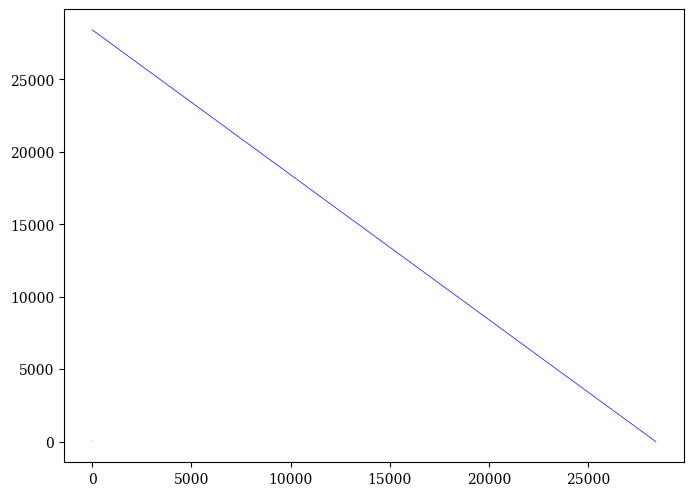

In [25]:
fig, ax = plt.subplots(1, 1)
ria = [1,2,3,4,5]
ax.plot(ria,color='red', label = "j17", linewidth=0.5)
ax.plot(df_27,color='blue', label = "j27", linewidth=0.5)
ax.plot(df_h,color='green',label = 'hondo', linewidth=0.5)
ax.set_title("data visualization", size=15)
ax.set_xlabel("time step", size=12)
ax.set_ylabel("gwl", size=12)
ax.legend(prop={'size': 10})

In [21]:
# build LSTM
model = Sequential()
model.add(LSTM(30, return_sequences=True, activation='sigmoid', input_shape=(num_lags, 1))) #return_sequences=True,
model.add(LSTM(30))
#model.add(LSTM(10, activation='sigmoid'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(ds_train_x, ds_train_y, epochs=20)
# apply to predictions
predictions = model.predict(ds_val_x)
result = []
for i in predictions:
  result.append(i[0])
result = np.array(result)
predicted_vals = result * std + mean
true_vals = ds_val_y * std + mean
diff = true_vals - predicted_vals
count_err = 0
count_1 = 0
for i in diff:
    if abs(i) <= err_range:
      count_err += 1
    if abs(i) <= 1.0:
      count_1 += 1
print("Predictions ±" + str(err_range) + " = " + str(count_err / len(diff) * 100) + "%")
print("Predictions ±1.0 = " + str(count_1 / len(diff) * 100) + "%")
corr_m = np.corrcoef(ds_val_y*std+mean, result*std+mean)
r2 = corr_m[0,1] ** 2
print('R2 = ' + str(r2*100) + "%")

Epoch 1/20
2183/2183 [==============================] - 8s 2ms/step - loss: 0.1066
Epoch 2/20
2183/2183 [==============================] - 5s 2ms/step - loss: 0.0803
Epoch 3/20
2183/2183 [==============================] - 5s 2ms/step - loss: 0.0786
Epoch 4/20
2183/2183 [==============================] - 5s 2ms/step - loss: 0.0772
Epoch 5/20
2183/2183 [==============================] - 5s 2ms/step - loss: 0.0760
Epoch 6/20
2183/2183 [==============================] - 5s 2ms/step - loss: 0.0751
Epoch 7/20
2183/2183 [==============================] - 5s 2ms/step - loss: 0.0746
Epoch 8/20
2183/2183 [==============================] - 5s 2ms/step - loss: 0.0744
Epoch 9/20
2183/2183 [==============================] - 5s 2ms/step - loss: 0.0740
Epoch 10/20
2183/2183 [==============================] - 5s 2ms/step - loss: 0.0741
Epoch 11/20
2183/2183 [==============================] - 5s 2ms/step - loss: 0.0739
Epoch 12/20
2183/2183 [==============================] - 5s 2ms/step - loss: 0.0738
E

In [22]:
plt.rcParams['font.family'] = 'serif'
f='Times'

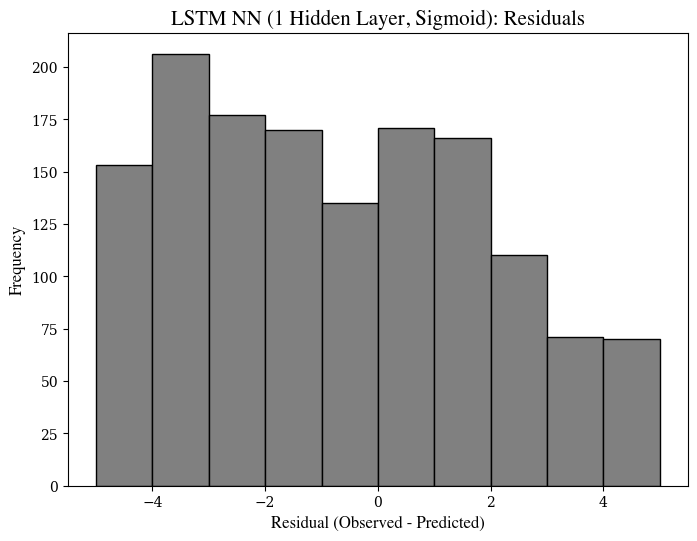

In [23]:
fig, ax = plt.subplots(1, 1)
ax.hist(diff,range=[-5, 5],facecolor='grey',edgecolor='black')
ax.set_title("LSTM NN (1 Hidden Layer, Sigmoid): Residuals", family=f, size=15)
ax.set_xlabel("Residual (Observed - Predicted)", family=f, size=12)
ax.set_ylabel("Frequency", family=f, size=12)
plt.show()

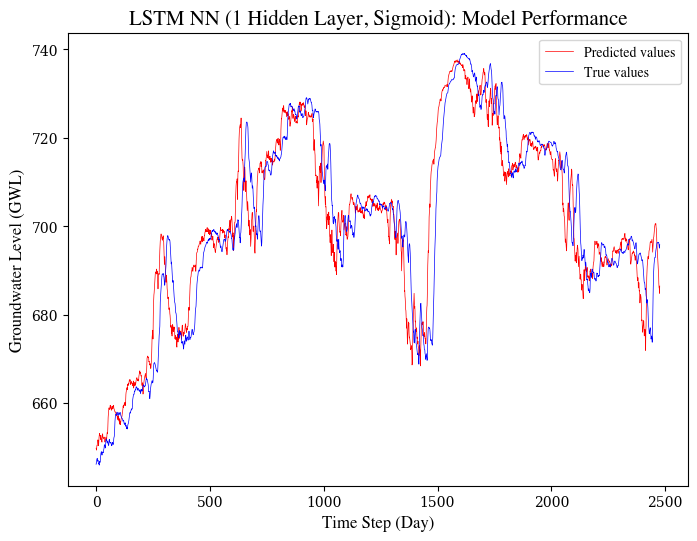

In [19]:
fig, ax = plt.subplots(1, 1)
ax.plot(predicted_vals,color='red', label = "Predicted values", linewidth=0.5)
ax.plot(true_vals,color='blue', label = "True values", linewidth=0.5)
ax.set_title("LSTM NN (1 Hidden Layer, Sigmoid): Model Performance", family=f, size=15)
ax.set_xlabel("Time Step (Day)", family=f, size=12)
ax.set_ylabel("Groundwater Level (GWL)", family=f, size=12)
ax.legend(prop={'size': 10, 'family':f})